In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install datasets
import gensim
import pandas as pd
import argparse
import numpy as np
from datasets import load_dataset
import os
import torch
import pickle
import re
import time
import copy
import math
from torch.utils.data import DataLoader, Dataset
import torch.optim as optimizer 
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['Times New Roman']
sns.set_style("whitegrid")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set(font_scale=1.2)

In [ ]:
data_dir = '/content/gdrive/MyDrive/530proj_me'
def clean_text(w):
    return re.sub(
            r"([.,'!?\"()*#:;])",
            '',
            w.lower()
            ).replace('-', ' ').replace('/', ' ')
def preprocessing(train=False, eval=False, test=False):
  # label col:  "pants-fire" : 0, "false" : 1, "barely-true" : 2, "half-true" : 3, "mostly-true" : 4, "true" : 5
  if train:
    current_dataset = load_dataset("liar", split="train")
  if eval:
    current_dataset = load_dataset('liar', split='validation')
  if test:
    current_dataset = load_dataset('liar', split='test')
  return current_dataset

def get_word2vec_embedding(statements, data_dir):
  token_file = os.path.join(data_dir,'token_to_ix.pkl')
  w2v_file = os.path.join(data_dir,'train_w2v.npy')

  if os.path.exists(w2v_file) and os.path.exists(token_file):
        print("Loading train language files")
        return pickle.load(open(token_file, "rb")), np.load(w2v_file)

  token2ix = {'PAD': 0, 'UNK': 1}
  for s in statements:
    s = clean_text(s).split()
    for word in s:
      if word not in token2ix:
        token2ix[word] = len(token2ix)
  ix2token = {token2ix[k]: k for k in token2ix.keys()}
  w2v_path = '/content/gdrive/MyDrive/530project/GoogleNews-vectors-negative300.bin.gz'
  w2vmodel = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)
  pretrained_emb = torch.randn([len(token2ix),300])
  for i in range(len(token2ix)):
    word = ix2token[i]
    if word in w2vmodel:
      vec = w2vmodel[word]
      pretrained_emb[i, :] = torch.from_numpy(vec)
  np.save(w2v_file, pretrained_emb)
  pickle.dump(token2ix, open(token_file, "wb"))
  return token2ix, pretrained_emb


def get_glove_embedding(statements, data_dir):
  token_file = os.path.join(data_dir,'token_to_ix.pkl')
  glove_file = os.path.join(data_dir,'train_glove.npy')

  if os.path.exists(glove_file) and os.path.exists(token_file):
        print("Loading train language files")
        return pickle.load(open(token_file, "rb")), np.load(glove_file)

  token2ix = {'PAD': 0, 'UNK': 1}
  for s in statements:
    s = clean_text(s).split()
    for word in s:
      if word not in token2ix:
        token2ix[word] = len(token2ix)
  glove_path = '/content/gdrive/MyDrive/530project/glove.6B.300d.txt'
  embeddings = {}
  with open(glove_path) as f:
    for line in f:
      field = line.split()
      word = field[0]
      vec = np.array(field[1:], dtype="float32")
      embeddings[word.lower()]= vec

  ix2token = {ix: w for w, ix in token2ix.items()}
  ix2emb = {}
  for ix in range(len(token2ix)):
    word = ix2token[ix]
    if word in embeddings:
      ix2emb[ix] = embeddings[word]
    else:
      ix2emb[ix] = [0] * EMBEDDING_DIM
  ix2emb = [ix2emb[ix] for ix in range(len(token2ix))]
  pretrained_emb = np.array(ix2emb)
  np.save(glove_file, pretrained_emb)
  pickle.dump(token2ix, open(token_file, "wb"))
  return token2ix, pretrained_emb

def embed_text(x, max_len, token2ix):
  ques_ix = np.zeros(max_len, np.int64)
  x = clean_text(x).split()
  for ix, word in enumerate(x):
    if word in token2ix:
      ques_ix[ix] = token2ix[word]
    else:
      ques_ix[ix] = 1
    if ix + 1 == max_len:
      break
  return ques_ix
def category_from_output(output):
  res = []
  for i in output:
    top_n, top_i = i.topk(1)
    category_i = top_i[0].item()
    res.append(category_i)
  return res
# for batch_idx, (text, label) in enumerate(train_data_iter):
#     text, label = text.to(device), label.to(device)
#     output = best_model(text)
#     print(output)
#     loss = criteon(output,label)
#     print(category_from_output(output))
#     break

In [ ]:
class liar_dataset(Dataset):
  def __init__(self, dst):
    self.embedded = np.array(dst['embedded'])
    self.label = np.array(dst['label'])
  def __getitem__(self, index):
    return self.embedded[index],\
          self.label[index],
  def __len__(self):
    return len(self.label)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EMBEDDING_DIM = 300
BATCH_SIZE = 64
LEARNING_RATE = 0.005
EPOCH = 11

train_dataset = pd.DataFrame(preprocessing(train=True))
statements = train_dataset['statement']
# token2ix, pretrained_emb = get_glove_embedding(statements, data_dir)
token2ix, pretrained_emb = get_word2vec_embedding(statements, data_dir)
print(pretrained_emb.shape) # (len(vocab), embedding_dim)
lengths = [len(x.split()) for x in statements]
max_len = int(np.percentile(lengths,90))

train_dataset['embedded'] = train_dataset['statement'].apply(lambda x: embed_text(x, max_len, token2ix))
train_dst = liar_dataset(train_dataset)
train_data_iter = DataLoader(train_dst, batch_size=BATCH_SIZE, shuffle=True)

dev_dataset = pd.DataFrame(preprocessing(eval=True))
dev_dataset['embedded'] = dev_dataset['statement'].apply(lambda x: embed_text(x, max_len, token2ix))
dev_dst = liar_dataset(dev_dataset)
dev_data_iter = DataLoader(dev_dst, batch_size=BATCH_SIZE, shuffle=True)

Using custom data configuration default
Reusing dataset liar (/root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)


Loading train language files
(12969, 300)


Using custom data configuration default
Reusing dataset liar (/root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)


In [ ]:
class CNN_model(nn.Module):
    def __init__(self, token_size, pretrained_emb):
        super(CNN_model, self).__init__()
        num_class = 6
        dropout_rate = 0.5
        self.embedding = nn.Embedding(
            num_embeddings=token_size,
            embedding_dim=300
        )
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_emb))
        self.conv_unit1 = nn.Sequential(
            torch.nn.Conv1d(in_channels=300, out_channels=128, kernel_size=2),
            torch.nn.MaxPool1d(kernel_size=2),
            # torch.nn.AdaptiveMaxPool1d(output_size),
        )
        self.conv_unit2 = nn.Sequential(
            torch.nn.Conv1d(in_channels=300, out_channels=128, kernel_size=3),
            torch.nn.MaxPool1d(kernel_size=3),
        )
        self.conv_unit3 = nn.Sequential(
            torch.nn.Conv1d(in_channels=300, out_channels=128, kernel_size=4),
            torch.nn.MaxPool1d(kernel_size=4),
        )

        # self.convs = nn.ModuleList([nn.Conv2d(1, 100, (w, 200)) for w in kernel_wins])
        self.dropout = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(128, num_class)
        self.fc_unit = nn.Sequential(nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(32, 6)
        )

    def forward(self, x):
      x = self.embedding(x) # [4, len, 300]
      x = torch.transpose(x,1,2)
      x1 = self.conv_unit1(x) # x1: [4, 128, len_a]
      x2 = self.conv_unit2(x) # x2: [4, 128, len_b]
      x3 = self.conv_unit3(x) # x3: [4, 128, len_c]
      x = torch.cat((x1,x2,x3), dim=2) # x: [4, 128, len_d]
      x = x.squeeze(-1) # x: [4, 128, len_d]
      x = self.dropout(x) # torch.Size([4, 128, len_d])
      x = x[:,:,-1] # [4, 128]
      # print(x.shape)
      # logit = self.fc_unit(x) # [4, 6]
      logit = self.fc(x) # [4, 6]
      # print(logit.shape)
      return logit
    
# debug
# net = CNN_model(len(token2ix), pretrained_emb).to(device)
# criteon = nn.CrossEntropyLoss().to(device)
# for batch_idx, (text, label) in enumerate(train_data_iter):
#     text, label = text.to(device), label.to(device)
#     output = net(text)
#     print(output)
#     loss = criteon(output,label)
#     break

In [ ]:
def train(epoch,train_data_iter,dev_data_iter,opt,criteon,net,device):
  def timeSince(since):
      now = time.time()
      s = now - since
      m = math.floor(s / 60)
      s -= m * 60
      return '%dm %ds' % (m, s)
  train_losses, dev_losses, dev_acc_list = [], [], []
  best_model, best_val_acc = None, float('-inf')
  cnt_step = 0
  current_loss = 0
  plot_every = 2
  dev_every = 2
  print('train len:',len(train_data_iter),'dev len:',len(dev_data_iter))
  print('learning_rate',LEARNING_RATE,'n_iters',EPOCH, 'optim','Adam', 'lr_scheduler',None, 'device',device)
  start = time.time()
  for e in range(epoch): 
    print('Epoch', e)
    net.train()
    for batch_idx, (text, label) in enumerate(train_data_iter):
      text, label = text.to(device), label.to(device)
      output = net(text)
      loss = criteon(output,label)
      current_loss += loss
      cnt_step += 1
      opt.zero_grad()
      loss.backward()
      opt.step()
    if e==0:
      print(time.time()-start)
    if e % plot_every == 0:
      tmp_loss = current_loss.item() / cnt_step
      train_losses.append(tmp_loss)
      current_loss, cnt_step = 0, 0
      print('%d %d%% (%s) %.4f ' % (e, e / EPOCH * 100, timeSince(start), tmp_loss))
    if e % dev_every ==0:
      net.eval()
      eval_loss = 0
      y_pred, y_true = [], []
      cnt_eval_step = 0
      for batch_idx, (text, label) in enumerate(dev_data_iter):
        text, label = text.to(device), label.to(device)
        output = net(text)
        categories = category_from_output(output)
        loss = criteon(output,label)
        eval_loss += loss
        cnt_eval_step += 1

        y_pred += categories
        y_true += label.tolist()
      # print(cnt_eval_step, eval_loss, len(dev_data_iter))
      dev_losses.append(eval_loss.item()/cnt_eval_step)
      acc = accuracy_score(y_pred,y_true)
      dev_acc_list.append(acc)
      if acc>best_val_acc:
        best_val_acc = acc
        best_model = copy.deepcopy(net)
      print('%d %d%% (%s) %.4f %s %s %.4f' % (e, e / EPOCH * 100, timeSince(start), eval_loss.item()/cnt_eval_step, categories, label.tolist(), acc))
  print('best_val_acc',best_val_acc)
  return train_losses, dev_losses, dev_acc_list, best_model # best_model

In [ ]:
# word2vec embedding
LEARNING_RATE = 0.002
net = CNN_model(len(token2ix), pretrained_emb).to(device)
# opt = optimizer.Adam(net.parameters(), lr=LEARNING_RATE)
opt = optimizer.SGD(net.parameters(), lr=LEARNING_RATE)
criteon = nn.CrossEntropyLoss().to(device)
train_losses, dev_losses, dev_acc_list, best_model = train(51,train_data_iter,dev_data_iter,opt,criteon,net,device)

train len: 161 dev len: 21
learning_rate 0.002 n_iters 11 optim Adam lr_scheduler None device cuda:0
Epoch 0
1.3062055110931396
0 0% (0m 1s) 1.7997 
0 0% (0m 1s) 1.7781 [0, 0, 0, 2] [4, 1, 3, 1] 0.2173
Epoch 1
Epoch 2
2 18% (0m 3s) 1.7786 
2 18% (0m 3s) 1.7652 [2, 0, 0, 0] [5, 2, 0, 0] 0.2173
Epoch 3
Epoch 4
4 36% (0m 6s) 1.7681 
4 36% (0m 6s) 1.7640 [0, 0, 0, 0] [4, 2, 2, 2] 0.2251
Epoch 5
Epoch 6
6 54% (0m 8s) 1.7651 
6 54% (0m 9s) 1.7684 [2, 1, 1, 0] [4, 3, 3, 4] 0.2235
Epoch 7
Epoch 8
8 72% (0m 11s) 1.7612 
8 72% (0m 11s) 1.7618 [0, 2, 0, 0] [2, 4, 1, 0] 0.2227
Epoch 9
Epoch 10
10 90% (0m 13s) 1.7610 
10 90% (0m 14s) 1.7712 [0, 1, 0, 0] [3, 0, 0, 5] 0.2235
Epoch 11
Epoch 12
12 109% (0m 16s) 1.7593 
12 109% (0m 16s) 1.7708 [1, 2, 0, 0] [1, 3, 0, 5] 0.2227
Epoch 13
Epoch 14
14 127% (0m 18s) 1.7571 
14 127% (0m 19s) 1.7623 [0, 0, 2, 0] [3, 4, 2, 0] 0.2220
Epoch 15
Epoch 16
16 145% (0m 21s) 1.7576 
16 145% (0m 21s) 1.7620 [0, 1, 0, 0] [2, 2, 0, 4] 0.2220
Epoch 17
Epoch 18
18 163% (0m 2

In [ ]:
# Glove embedding
net = CNN_model(len(token2ix), pretrained_emb).to(device)
# opt = optimizer.Adam(net.parameters(), lr=LEARNING_RATE)
opt = optimizer.SGD(net.parameters(), lr=LEARNING_RATE)
criteon = nn.CrossEntropyLoss().to(device)
train_losses, dev_losses, dev_acc_list, best_model = train(51,train_data_iter,dev_data_iter,opt,criteon,net,device)

train len: 161 dev len: 21
learning_rate 0.005 n_iters 11 optim Adam lr_scheduler None device cuda:0
Epoch 0
1.3058865070343018
0 0% (0m 1s) 1.7880 
0 0% (0m 1s) 1.7760 [1, 2, 2, 2] [1, 0, 1, 3] 0.1978
Epoch 1
Epoch 2
2 18% (0m 3s) 1.7717 
2 18% (0m 3s) 1.7690 [2, 2, 2, 2] [5, 1, 1, 0] 0.2002
Epoch 3
Epoch 4
4 36% (0m 6s) 1.7630 
4 36% (0m 6s) 1.7579 [0, 0, 0, 1] [0, 4, 0, 1] 0.2173
Epoch 5
Epoch 6
6 54% (0m 8s) 1.7579 
6 54% (0m 8s) 1.7776 [1, 0, 1, 1] [2, 5, 3, 5] 0.2196
Epoch 7
Epoch 8
8 72% (0m 11s) 1.7551 
8 72% (0m 11s) 1.7583 [0, 0, 0, 0] [2, 4, 0, 1] 0.2188
Epoch 9
Epoch 10
10 90% (0m 13s) 1.7530 
10 90% (0m 13s) 1.7584 [0, 0, 1, 0] [2, 2, 3, 2] 0.2196
Epoch 11
Epoch 12
12 109% (0m 15s) 1.7513 
12 109% (0m 16s) 1.7574 [0, 0, 0, 0] [1, 2, 4, 2] 0.2181
Epoch 13
Epoch 14
14 127% (0m 18s) 1.7494 
14 127% (0m 18s) 1.7569 [1, 1, 0, 1] [1, 3, 4, 0] 0.2181
Epoch 15
Epoch 16
16 145% (0m 20s) 1.7479 
16 145% (0m 20s) 1.7594 [1, 0, 1, 1] [3, 2, 0, 3] 0.2181
Epoch 17
Epoch 18
18 163% (0m 2

In [ ]:
torch.save(best_model.state_dict(), os.path.join(data_dir,'model_weights_singleCNN_acc227.pth'))

In [ ]:
print(train_losses)
print(dev_losses)
print(dev_acc_list)

[1.7996811007861024, 1.778634018039111, 1.7681297160083462, 1.7650929326596467, 1.7612467700650234, 1.7609675626577057, 1.7592574409816577, 1.757096568990198, 1.7575704444269216, 1.7558273410204774, 1.7549379716008346, 1.7535269601004464, 1.7533885884729232, 1.7526303877741654, 1.7520962353818905, 1.752901065423622, 1.7519698054153727, 1.7515078716396546, 1.750999687621312, 1.749473240064538, 1.7499965880968555, 1.7482840022685364, 1.749182659646739, 1.747830787800854, 1.747785674859278, 1.7483742281516887]
[1.7780523754301525, 1.7652311779203869, 1.7640380859375, 1.7684377034505208, 1.7618077596028645, 1.7711759294782365, 1.7708338782900857, 1.762317839122954, 1.7619507199242002, 1.7675107320149739, 1.7581000555129278, 1.7597416469029017, 1.7653735932849703, 1.776895250592913, 1.7719957260858445, 1.7689739408947172, 1.760849362327939, 1.7568851652599515, 1.7697040012904577, 1.7607007707868303, 1.778027125767299, 1.7590838841029577, 1.7595336550757998, 1.7633677891322546, 1.76868820190

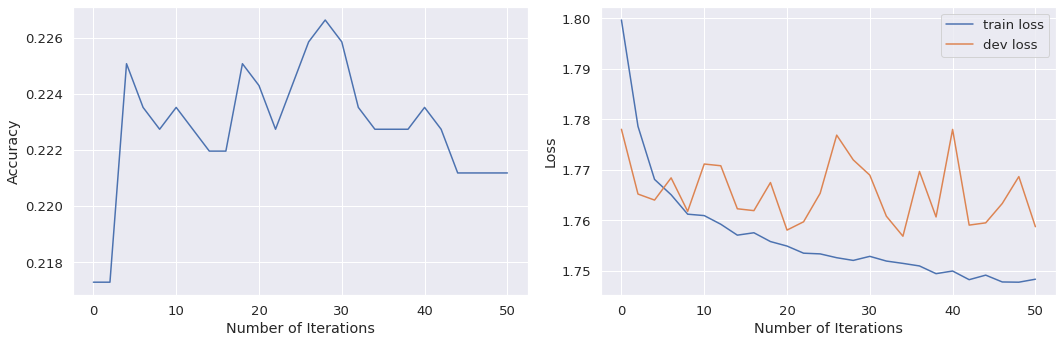

In [ ]:
import warnings
warnings.filterwarnings("ignore")
fig, ((ax1, ax2))= plt.subplots(1,2,figsize = (15,5))
x_axis = [i*2 for i in range(len(dev_losses))]
sns.lineplot(x_axis, dev_acc_list, ax = ax1)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel("Number of Iterations")
sns.lineplot(x_axis, train_losses, ax = ax2,label = 'train loss')
sns.lineplot(x_axis, dev_losses, ax = ax2, label = 'dev loss')
ax2.set_ylabel("Loss")
ax2.set_xlabel("Number of Iterations")
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
X_train, y_train = np.array([i for i in train_dataset['embedded']]), np.array(train_dataset['label'])

X_dev, y_dev = np.array([i for i in dev_dataset['embedded']]), np.array(dev_dataset['label'])
models = {'SVC': SVC(), 'logistic': LogisticRegression()}
for m in models:
  print(m, end = ' ')
  model = models[m]
  model.fit(X_train, y_train)
  y_pred = model.predict(X_dev)
  acc = accuracy_score(y_pred,y_dev)
  print('accuracy: ',acc)

SVC accuracy:  0.22741433021806853
logistic accuracy:  0.19626168224299065


## Process meta-data

In [ ]:
class hybrid_CNN(nn.Module):
    def __init__(self, token_size, pretrained_emb):
        super(hybrid_CNN, self).__init__()
        num_class = 6
        dropout_rate = 0.8
        self.embedding = nn.Embedding(
            num_embeddings=token_size,
            embedding_dim=300
        )
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_emb))
        self.conv_unit1 = nn.Sequential(
            torch.nn.Conv1d(in_channels=300, out_channels=128, kernel_size=2),
            torch.nn.MaxPool1d(kernel_size=2),
            # torch.nn.AdaptiveMaxPool1d(output_size),
        )
        self.conv_unit2 = nn.Sequential(
            torch.nn.Conv1d(in_channels=300, out_channels=128, kernel_size=3),
            torch.nn.MaxPool1d(kernel_size=3),
        )
        self.conv_unit3 = nn.Sequential(
            torch.nn.Conv1d(in_channels=300, out_channels=128, kernel_size=4),
            torch.nn.MaxPool1d(kernel_size=4),
        )

        # self.convs = nn.ModuleList([nn.Conv2d(1, 100, (w, 200)) for w in kernel_wins])
        self.dropout = nn.Dropout(dropout_rate)

        # self.fc = nn.Linear(128, num_class)
        self.fc_unit = nn.Sequential(nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(32, 6)
        )
        self.fc_concat = nn.Sequential(nn.Linear(128,64), nn.ReLU())
      

## Evaluate on test set

In [ ]:
def evaluate(test_data_iter, best_model):
  y_pred, y_true = [], []
  best_model.eval()
  for batch_idx, (text, label) in enumerate(test_data_iter):
    text, label = text.to(device), label.to(device)
    output = best_model(text)

    categories = category_from_output(output)
    loss = criteon(output,label)
    y_pred += categories
    y_true += label.tolist()
    
  acc = accuracy_score(y_pred,y_true)
  return acc, y_pred

In [ ]:
test_dataset = pd.DataFrame(preprocessing(test=True))
test_dataset['embedded'] = test_dataset['statement'].apply(lambda x: embed_text(x, max_len, token2ix))
test_dst = liar_dataset(test_dataset)
test_data_iter = DataLoader(test_dst, batch_size=BATCH_SIZE, shuffle=True)

acc, y_pred = evaluate(test_data_iter, best_model)

Using custom data configuration default
Reusing dataset liar (/root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514)


In [ ]:
acc

0.2182385035074045